In [438]:
!pip install catboost

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgbm
import catboost as ctb

from google.colab import drive

In [440]:
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## functions

In [0]:
# evaluate model under classification report

def my_model(model, x_train, y_train, x_test, y_test):
    model = model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    print(classification_report(y_test, y_pred))

## data upload

In [442]:
df = pd.read_csv('drive/My Drive/geek_data/_project/course_project_train.csv')
print(df.shape)
df.head()

(7500, 17)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,nan,1.00,debt consolidation,Short Term,99999999.00,47386.00,7914.00,749.00,0
1,Own Home,1025487.00,10+ years,0.00,15.00,15.30,1181730.00,0.00,nan,0.00,debt consolidation,Long Term,264968.00,394972.00,18373.00,737.00,1
2,Home Mortgage,751412.00,8 years,0.00,11.00,35.00,1182434.00,0.00,nan,0.00,debt consolidation,Short Term,99999999.00,308389.00,13651.00,742.00,0
3,Own Home,805068.00,6 years,0.00,8.00,22.50,147400.00,1.00,nan,1.00,debt consolidation,Short Term,121396.00,95855.00,11338.00,694.00,0
4,Rent,776264.00,8 years,0.00,13.00,13.60,385836.00,1.00,nan,0.00,debt consolidation,Short Term,125840.00,93309.00,7180.00,719.00,0


In [443]:
df_test = pd.read_csv('drive/My Drive/geek_data/_project/course_project_test.csv')
print(df_test.shape)
df_test.head()

(2500, 16)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,nan,4 years,0.00,9.00,12.50,220968.00,0.00,70.00,0.00,debt consolidation,Short Term,162470.00,105906.00,6813.00,nan
1,Rent,231838.00,1 year,0.00,6.00,32.70,55946.00,0.00,8.00,0.00,educational expenses,Short Term,78298.00,46037.00,2318.00,699.00
2,Home Mortgage,1152540.00,3 years,0.00,10.00,13.70,204600.00,0.00,nan,0.00,debt consolidation,Short Term,200178.00,146490.00,18729.00,7260.00
3,Home Mortgage,1220313.00,10+ years,0.00,16.00,17.00,456302.00,0.00,70.00,0.00,debt consolidation,Short Term,217382.00,213199.00,27559.00,739.00
4,Home Mortgage,2340952.00,6 years,0.00,11.00,23.60,1207272.00,0.00,nan,0.00,debt consolidation,Long Term,777634.00,425391.00,42605.00,706.00


## preprocessing

### general analysis

In [444]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [445]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

In [446]:
# checking inbalance
print(df['Credit Default'].value_counts())

0    5387
1    2113
Name: Credit Default, dtype: int64


### replacing nan

In [0]:
df.loc[df['Annual Income'].isnull(), 'Annual Income'] = df['Annual Income'].mean()
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = df_test['Annual Income'].mean()

In [0]:
df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

In [0]:
df.loc[df['Credit Score'].isnull(), 'Credit Score'] = 0
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = 0

In [450]:
print(df['Bankruptcies'].value_counts())
print(df_test['Bankruptcies'].value_counts())

df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = df['Bankruptcies'].median()
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = df_test['Bankruptcies'].median()

0.00    6660
1.00     786
2.00      31
3.00       7
4.00       2
Name: Bankruptcies, dtype: int64
0.00    2252
1.00     234
2.00       5
3.00       3
5.00       2
4.00       1
Name: Bankruptcies, dtype: int64


In [451]:
print(df_test['Bankruptcies'].value_counts())

df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = df['Bankruptcies'].median()

0.00    2255
1.00     234
2.00       5
3.00       3
5.00       2
4.00       1
Name: Bankruptcies, dtype: int64


In [0]:
df.loc[df['Years in current job'].isnull(), 'Years in current job'] = 'na'
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 'na'

In [453]:
for i in [len(df) - df.count()]:
    print(*i)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [454]:
for i in [len(df_test) - df_test.count()]:
    print(*i)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


### processing outliers

In [455]:
pd.set_option('float_format', '{:.2f}'.format)
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1366391.72,0.03,11.13,18.32,945153.73,0.17,15.82,0.12,11873177.45,289833.24,18314.45,912.12,0.28
std,752481.20,0.27,4.91,7.04,16026216.67,0.50,22.65,0.35,31926122.97,317871.38,11926.76,1502.59,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,0.00,0.00
25%,931133.00,0.00,8.00,13.50,279229.50,0.00,0.00,0.00,180169.00,114256.50,10067.50,667.00,0.00
50%,1366391.72,0.00,10.00,17.00,478159.00,0.00,0.00,0.00,309573.00,209323.00,16076.50,722.00,0.00
75%,1499974.00,0.00,14.00,21.80,793501.50,0.00,29.00,0.00,519882.00,360406.25,23818.00,740.00,1.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00,1.00


In [456]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2500.00,2500.00,2500.00,2500.00,2500.00,2500.00,2500.00,2500.00,2500.00,2500.00,2500.00,2500.00
mean,1366921.68,0.04,11.18,18.33,710570.41,0.16,15.61,0.11,12155719.63,296396.65,18271.34,981.19
std,817589.11,0.39,4.85,7.25,1511983.48,0.56,22.62,0.36,32260973.72,378301.97,11543.88,1629.53
min,106533.00,0.00,1.00,3.90,0.00,0.00,0.00,0.00,15422.00,0.00,93.00,0.00
25%,936562.25,0.00,8.00,13.40,278586.00,0.00,0.00,0.00,187126.50,110114.50,10024.75,668.00
50%,1366921.68,0.00,10.00,17.00,478676.00,0.00,0.00,0.00,322366.00,207385.00,16642.50,722.00
75%,1488726.00,0.00,14.00,22.10,802598.50,0.00,27.00,0.00,522582.50,366348.50,24146.00,741.00
max,14975610.00,15.00,48.00,53.40,54484386.00,15.00,82.00,5.00,99999999.00,6030087.00,93555.00,7480.00


In [0]:
df.loc[df['Maximum Open Credit'] > 1e8]
df.loc[df['Maximum Open Credit'] > 1e9, 'Maximum Open Credit'] = df['Maximum Open Credit'].mean()

### scanning features correlation

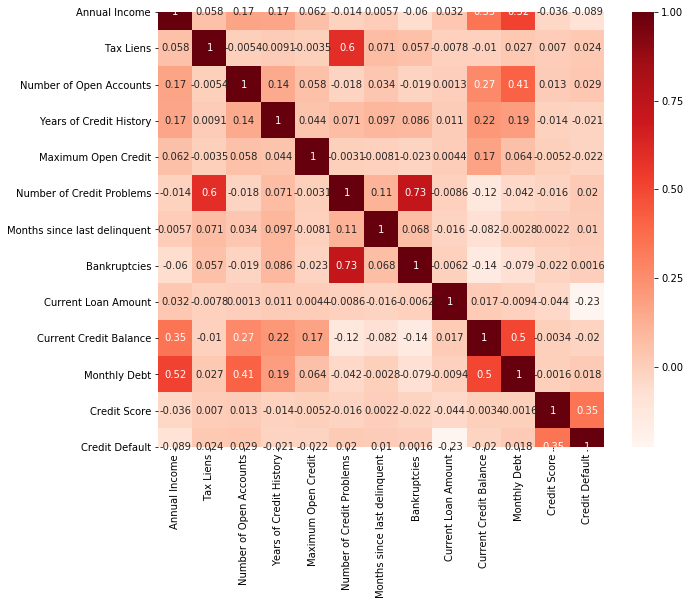

In [458]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

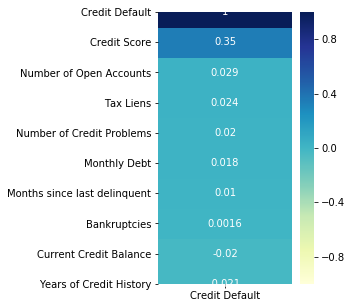

In [459]:
fig, ax = plt.subplots(figsize=(3,5))
sns.heatmap(df.corr()[['Credit Default']].sort_values('Credit Default').tail(10), 
            vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

In [460]:
cor_target = abs(df.corr()['Credit Default'])
imp_features = cor_target[cor_target > 0.10]
print(imp_features)

Current Loan Amount   0.23
Credit Score          0.35
Credit Default        1.00
Name: Credit Default, dtype: float64


### categorical features

In [0]:
# # for catboost only

# cat_feature_names = ['Home Ownership', 'Purpose', 'Term']

# for colname in cat_feature_names:
#     df[colname] = pd.Categorical(df[colname])
    
# df[cat_feature_names].dtypes

In [462]:
print(df['Home Ownership'].value_counts())
print(df_test['Home Ownership'].value_counts())

own_dum = pd.get_dummies(df['Home Ownership'], prefix='own_', dummy_na=False)
own_dum_test = pd.get_dummies(df_test['Home Ownership'], prefix='own_', dummy_na=False)

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64


In [463]:
print(df['Years in current job'].value_counts())
print(df_test['Years in current job'].value_counts())

years_dict = {'na': 0, '< 1 year': 1, '1 year': 2, '2 years': 3, '3 years': 4, 
              '4 years': 5, '5 years': 6, '6 years': 7, '7 years': 8,
              '8 years': 9, '9 years': 10, '10+ years': 11}

df['Years in current job'].replace(years_dict, inplace=True)
df_test['Years in current job'].replace(years_dict, inplace=True)

df['Years in current job'].fillna(df['Years in current job'].median(), inplace=True)
df_test['Years in current job'].fillna(df_test['Years in current job'].median(), inplace=True)

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
na            371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
na            86
Name: Years in current job, dtype: int64


In [464]:
print(df['Purpose'].value_counts())
print(df_test['Purpose'].value_counts())

purp_dum = pd.get_dummies(df['Purpose'], prefix='purp_', dummy_na=False)
purp_dum_test = pd.get_dummies(df_test['Purpose'], prefix='purp_', dummy_na=False)

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64


In [465]:
print(df['Term'].value_counts())
print(df_test['Term'].value_counts())

term_dum = pd.get_dummies(df['Term'], prefix='term_', dummy_na=True)
term_dum_test = pd.get_dummies(df_test['Term'], prefix='term_', dummy_na=True)

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
Short Term    1861
Long Term      639
Name: Term, dtype: int64


In [0]:
df = pd.concat([df, own_dum, purp_dum, term_dum], axis=1)
df_test = pd.concat([df_test, own_dum_test, purp_dum_test, term_dum_test], axis=1)

In [0]:
df.drop(columns=['Home Ownership', 'Purpose', 'Term'], axis=1, inplace=True)
df_test.drop(columns=['Home Ownership', 'Purpose', 'Term'], axis=1, inplace=True)

### generating new features

In [0]:
df['s_LoanToIncome'] = df['Current Loan Amount'] / df['Annual Income']
df['s_DebtToIncome'] = df['Monthly Debt'] / df['Annual Income']

df_test['s_LoanToIncome'] = df_test['Current Loan Amount'] / df_test['Annual Income']
df_test['s_DebtToIncome'] = df_test['Monthly Debt'] / df_test['Annual Income']

### scaling

In [469]:
scaler = StandardScaler()

scaler.fit(df.loc[:, df.columns != 'Credit Default'])
scaler.fit(df_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
# # for catbooster only
# df.select_dtypes(exclude='category')

# scaler = StandardScaler()

# scaler.fit(df.select_dtypes(exclude='category').loc[:, df.select_dtypes(exclude='category').columns != 'Credit Default'])

### balancing classes

In [0]:
cl0 = df.loc[df['Credit Default'] == 0]
cl1 = df.loc[df['Credit Default'] == 1]

In [0]:
cl1_up = resample(
    cl1,
    replace=True,
    n_samples=len(cl0),
    random_state=42
)

df = pd.concat([cl0, cl1_up])


### train test split

In [0]:
y = df['Credit Default']
x = df.drop(columns=['Credit Default'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42
)

## build, fit & predict

### base models

In [474]:
my_model(xgb.XGBClassifier(), x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1340
           1       0.71      0.70      0.70      1354

    accuracy                           0.70      2694
   macro avg       0.70      0.70      0.70      2694
weighted avg       0.70      0.70      0.70      2694



In [475]:
my_model(lgbm.LGBMClassifier(), x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1340
           1       0.79      0.82      0.80      1354

    accuracy                           0.80      2694
   macro avg       0.80      0.80      0.80      2694
weighted avg       0.80      0.80      0.80      2694



In [476]:
# # for the catboost working with categories

# categorical_features_indices = df.select_dtypes(include='category').columns.to_list()

# my_model(ctb.CatBoostClassifier(cat_features=categorical_features_indices), x_train, y_train, x_test, y_test)

my_model(ctb.CatBoostClassifier(random_state=42, verbose=0), x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1340
           1       0.82      0.83      0.82      1354

    accuracy                           0.82      2694
   macro avg       0.82      0.82      0.82      2694
weighted avg       0.82      0.82      0.82      2694



In [477]:
my_model(KNeighborsClassifier(), x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.69      0.58      0.63      1340
           1       0.64      0.74      0.69      1354

    accuracy                           0.66      2694
   macro avg       0.66      0.66      0.66      2694
weighted avg       0.66      0.66      0.66      2694



In [478]:
my_model(MultinomialNB(), x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       1.00      0.16      0.27      1340
           1       0.55      1.00      0.71      1354

    accuracy                           0.58      2694
   macro avg       0.77      0.58      0.49      2694
weighted avg       0.77      0.58      0.49      2694



In [479]:
my_model(SVC(), x_train, y_train, x_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1340
           1       1.00      0.85      0.92      1354

    accuracy                           0.93      2694
   macro avg       0.93      0.93      0.92      2694
weighted avg       0.93      0.93      0.92      2694



In [480]:
my_model(DecisionTreeClassifier(random_state=42), x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1340
           1       0.79      0.93      0.85      1354

    accuracy                           0.84      2694
   macro avg       0.85      0.84      0.84      2694
weighted avg       0.85      0.84      0.84      2694



In [481]:
my_model(RandomForestClassifier(), x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1340
           1       0.88      0.90      0.89      1354

    accuracy                           0.89      2694
   macro avg       0.89      0.89      0.89      2694
weighted avg       0.89      0.89      0.89      2694



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [482]:
my_model(LogisticRegression(), x_train, y_train, x_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.61      0.55      0.58      1340
           1       0.59      0.65      0.62      1354

    accuracy                           0.60      2694
   macro avg       0.60      0.60      0.60      2694
weighted avg       0.60      0.60      0.60      2694



### random search

#### xgboost

In [483]:
params = {
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
    'max_depth'        : [8, 10, 12, 15, 30, 45, 55],
    'min_child_weight' : [1, 3, 5, 7],
    'gamma'            : [0.0, 0.1, 0.2 , 0.3, 0.4],
    'colsample_bytree' : [0.3, 0.4, 0.5, 0.7],
    'subsample'        : [0.6, 0.8, 1.0]
}

model = xgb.XGBClassifier()

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

rand_search = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=4, 
    cv=skf.split(x_train, y_train),
    verbose=3, 
    random_state=42
)

rand_search.fit(x_train, y_train)

print('\n all results:')
print(rand_search.cv_results_)
print('\n best estimator:')
print(rand_search.best_estimator_)
print('\n best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(rand_search.best_score_ * 2 - 1)
print('\n best hyperparameters:')
print(rand_search.best_params_)

y_pred = rand_search.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   39.9s finished



 all results:
{'mean_fit_time': array([6.8025435 , 3.35816002, 4.9168736 , 8.37637606, 4.30899148]), 'std_fit_time': array([0.15013539, 0.11007132, 0.11397665, 0.16681581, 0.67395284]), 'mean_score_time': array([0.0826251 , 0.06378293, 0.0757441 , 0.09055672, 0.04473991]), 'std_score_time': array([0.01495212, 0.00446553, 0.01621595, 0.00309117, 0.01633816]), 'param_subsample': masked_array(data=[0.8, 1.0, 1.0, 0.8, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[7, 5, 1, 5, 7],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[15, 10, 10, 45, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.15, 0.25, 0.25, 0.1, 0.15],
             mask=[False, False, False, False, False],
       fill_

#### lgboost

In [484]:
params = {
    'num_leaves'       : np.arange(25, 60, 5),
    'max_depth'        : np.arange(-1, 9, 2),
    'learning_rate'    : np.arange(0.1, 1, 0.2),
    'n_estimators'     : np.arange(80, 200, 20),
    'subsample_for_bin': np.arange(190000, 240000, 20000),
    'min_split_gain'   : np.arange(0, 1.0, 0.2),
    'min_child_weight' : [1e-3, 1e-2, 1e-1],
    'min_child_samples': np.arange(20, 200, 10),
    'subsample'        : np.arange(0.2, 1.0, 0.2),
    'colsample_bytree' : np.arange(0.2, 1.0, 0.2)
}

model = xgb.XGBClassifier()

folds = 10
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

rand_search = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=4, 
    cv=skf.split(x_train, y_train),
    verbose=3, 
    random_state=42
)

rand_search.fit(x_train, y_train)

print('\n all results:')
print(rand_search.cv_results_)
print('\n best estimator:')
print(rand_search.best_estimator_)
print('\n best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(rand_search.best_score_ * 2 - 1)
print('\n best hyperparameters:')
print(rand_search.best_params_)

y_pred = rand_search.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   24.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   49.3s finished



 all results:
{'mean_fit_time': array([2.73684621, 2.04960136, 8.31591609, 1.44022915, 3.11996372]), 'std_fit_time': array([0.23259289, 0.06694731, 0.11463244, 0.01553307, 0.53699542]), 'mean_score_time': array([0.02771881, 0.0253572 , 0.04460859, 0.01786034, 0.02069235]), 'std_score_time': array([0.0093869 , 0.0060942 , 0.00809254, 0.00415339, 0.00773511]), 'param_subsample_for_bin': masked_array(data=[210000, 230000, 210000, 210000, 190000],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.4, 0.2, 0.6000000000000001, 0.4, 0.2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_num_leaves': masked_array(data=[55, 50, 25, 55, 25],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[160, 100, 160, 160, 180],
             mask=[False, Fals

#### catboost 

In [485]:
params = {
    'iterations'          : [1000, 2000],
    'learning_rate'       : [0.03, 0.1],
    'depth'               : [2, 3, 4, 6, 10],
    'loss_function'       : ['Logloss', 'CrossEntropy'],
    'l2_leaf_reg'         : [1, 3, 5, 7, 9, 20, 30],
    'max_bin'             : [32, 46, 100, 254],
    'bagging_temperature' : [0, 0.5, 1],
    'random_strength'     : [1, 5, 10],
    'iterations'          : [500, 750, 1000, 1250],
}

# model = ctb.CatBoostClassifier(cat_features=categorical_features_indices)
model = ctb.CatBoostClassifier()

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

rand_search = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=4, 
    cv=skf.split(x_train, y_train),
    verbose=3, 
    random_state=42
)

rand_search.fit(x_train, y_train)

print('\n all results:')
print(rand_search.cv_results_)
print('\n best estimator:')
print(rand_search.best_estimator_)
print('\n best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(rand_search.best_score_ * 2 - 1)
print('\n best hyperparameters:')
print(rand_search.best_params_)

y_pred = rand_search.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.8min finished


0:	learn: 0.6845422	total: 5.97ms	remaining: 2.98s
1:	learn: 0.6762498	total: 17.6ms	remaining: 4.38s
2:	learn: 0.6690577	total: 28ms	remaining: 4.64s
3:	learn: 0.6619422	total: 38.5ms	remaining: 4.77s
4:	learn: 0.6563381	total: 49.5ms	remaining: 4.9s
5:	learn: 0.6465404	total: 60ms	remaining: 4.94s
6:	learn: 0.6441889	total: 66.8ms	remaining: 4.7s
7:	learn: 0.6392694	total: 77.1ms	remaining: 4.74s
8:	learn: 0.6346601	total: 87.6ms	remaining: 4.78s
9:	learn: 0.6300113	total: 97.8ms	remaining: 4.79s
10:	learn: 0.6268052	total: 108ms	remaining: 4.81s
11:	learn: 0.6217501	total: 118ms	remaining: 4.81s
12:	learn: 0.6155780	total: 128ms	remaining: 4.81s
13:	learn: 0.6119126	total: 139ms	remaining: 4.82s
14:	learn: 0.6099764	total: 149ms	remaining: 4.82s
15:	learn: 0.6054059	total: 159ms	remaining: 4.82s
16:	learn: 0.6018227	total: 170ms	remaining: 4.82s
17:	learn: 0.5977663	total: 186ms	remaining: 4.97s
18:	learn: 0.5930927	total: 196ms	remaining: 4.97s
19:	learn: 0.5868716	total: 209ms	rem

### checking overfitting

[0]	validation_0-error:0.118564	validation_0-logloss:0.644024	validation_1-error:0.273571	validation_1-logloss:0.663445
[1]	validation_0-error:0.059282	validation_0-logloss:0.592256	validation_1-error:0.20193	validation_1-logloss:0.628397
[2]	validation_0-error:0.045545	validation_0-logloss:0.564605	validation_1-error:0.202673	validation_1-logloss:0.615234
[3]	validation_0-error:0.02797	validation_0-logloss:0.524005	validation_1-error:0.187082	validation_1-logloss:0.591299
[4]	validation_0-error:0.018441	validation_0-logloss:0.488399	validation_1-error:0.18003	validation_1-logloss:0.569658
[5]	validation_0-error:0.013861	validation_0-logloss:0.459884	validation_1-error:0.157387	validation_1-logloss:0.549524
[6]	validation_0-error:0.012252	validation_0-logloss:0.439384	validation_1-error:0.15516	validation_1-logloss:0.537298
[7]	validation_0-error:0.010272	validation_0-logloss:0.411867	validation_1-error:0.155531	validation_1-logloss:0.519696
[8]	validation_0-error:0.009406	validation_0

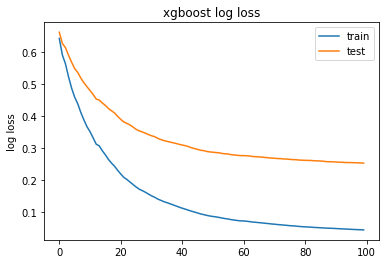

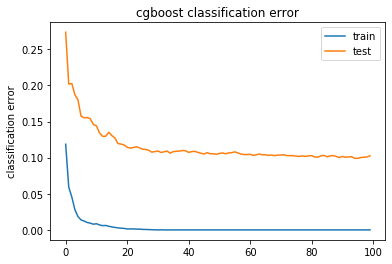

In [486]:
# final model

from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=45,
    min_child_weight=1,
    gamma=0.3,
    colsample_bytree=0.4,
    subsample=1.0,
    random_state=42,
)

eval_set = [(x_train, y_train), (x_test, y_test)]

model.fit(x_train, y_train, eval_metric=['error', 'logloss'], eval_set=eval_set, verbose=True)

y_pred = model.predict(x_test)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)

print(f'{accuracy * 100.0}')

results = model.evals_result()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='train')
ax.plot(x_axis, results['validation_1']['logloss'], label='test')
ax.legend()
plt.ylabel('log loss')
plt.title('xgboost log loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='train')
ax.plot(x_axis, results['validation_1']['error'], label='test')
ax.legend()
plt.ylabel('classification error')
plt.title('cgboost classification error')
plt.show()

### final model, predict & submit

In [487]:
model = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=45,
    min_child_weight=1,
    gamma=0.3,
    colsample_bytree=0.4,
    subsample=1.0,
    random_state=42
)

model.fit(x.drop(columns=['purp__renewable energy'], axis=1), y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=45,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1)

In [0]:
y_pred = model.predict(df_test)

In [489]:
print(df_test.shape, y_pred.shape)
print(pd.Series(y_pred).value_counts())
print(df_test.index)

(2500, 36) (2500,)
0    2135
1     365
dtype: int64
RangeIndex(start=0, stop=2500, step=1)


In [0]:
pd.DataFrame(y_pred, columns = ['Credit Default']).to_csv(
    'drive/My Drive/geek_data/_project/GKabanov_predictions.csv', 
    sep=',', 
    index=False
)